In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.shape

(20640, 10)

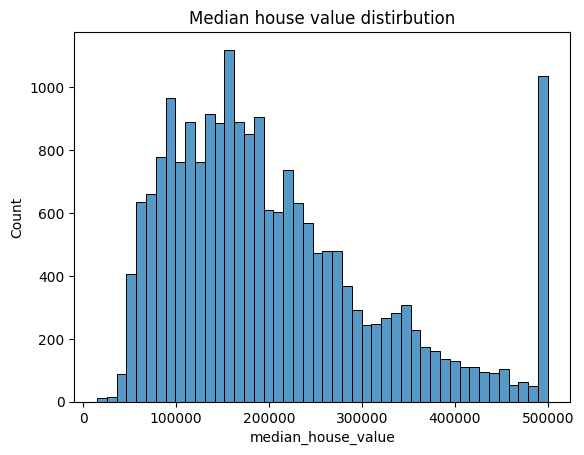

In [5]:
sns.histplot(df.median_house_value)
plt.title('Median house value distirbution')
plt.show()

In [6]:
df = df[['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']]

In [7]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [8]:
df.population.median()

1166.0

In [9]:
np.random.seed(42)

In [10]:
shuffle_index = np.arange(df.shape[0])

In [11]:
np.random.shuffle(shuffle_index)

In [12]:
shuffle_index

array([20046,  3024, 15663, ...,  5390,   860, 15795])

In [13]:
df_shuffled = df.iloc[shuffle_index]

In [14]:
df_shuffled.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
20046,36.06,-119.01,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0
3024,35.14,-119.46,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0
15663,37.80,-122.44,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0
20484,34.28,-118.72,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0
9814,36.62,-121.93,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0


In [15]:
n = df.shape[0]

In [16]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

In [17]:
df_train = df_shuffled.iloc[:n_train].reset_index(drop=True).copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].reset_index(drop=True).copy()
df_test = df_shuffled.iloc[n_train + n_val:].reset_index(drop=True).copy()

In [18]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [19]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [20]:
def train_linear_regression(X, y):
    # addind the dummy column
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    # normal equation formula
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [21]:
def rmse(y, y_pred):
    error = y_pred-y
    mse = (error**2).mean()
    return np.sqrt(mse)

* Filling the NaN with 0

In [22]:
X_train = df_train.fillna(0).values

In [23]:
w_0, w = train_linear_regression(X_train, y_train)

In [24]:
y_pred = w_0 + X_train.dot(w)

In [25]:
print(f' RMSE train filling NaN with 0: {rmse(y_train, y_pred):.2f}')

 RMSE train filling NaN with 0: 0.34


In [26]:
X_val = df_val.fillna(0).values

In [27]:
y_pred = w_0 + X_val.dot(w)

In [28]:
print(f' RMSE val filling NaN with 0: {rmse(y_val, y_pred):.2f}')

 RMSE val filling NaN with 0: 0.33


* Fillinf NaN with the mean of training data

In [29]:
X_train = df_train.fillna(df_train.total_bedrooms.mean()).values

In [30]:
w_0, w = train_linear_regression(X_train, y_train)

In [31]:
y_pred = w_0 + X_train.dot(w)

In [32]:
print(f' RMSE train filling NaN with 0: {rmse(y_train, y_pred):.2f}')

 RMSE train filling NaN with 0: 0.34


In [33]:
X_val = df_val.fillna(df_val.total_bedrooms.mean()).values

In [34]:
y_pred = w_0 + X_val.dot(w)

In [35]:
print(f' RMSE val filling NaN with the mean: {rmse(y_val, y_pred):.2f}')

 RMSE val filling NaN with the mean: 0.33


Fillinf NaN with the mean and cero seems to be equally good in this case

In [36]:
def train_linear_regression_reg(X, y, r=0.0):
    """Linear regression with regularization (Risdge Regression)
    parameter 'r' controls the amount of regularization"""
    # addind the dummy column
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    # normal equation formula and adding r to the main diagonal
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [37]:
X_train = df_train.fillna(0).values

In [38]:
X_val = df_val.fillna(0).values

In [39]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print(f'{r:>12} validation: {rmse(y_val, y_pred):.2f}')

           0 validation: 0.33
       1e-06 validation: 0.33
      0.0001 validation: 0.33
       0.001 validation: 0.33
        0.01 validation: 0.33
         0.1 validation: 0.33
           1 validation: 0.33
           5 validation: 0.34
          10 validation: 0.34


In [40]:
rmse_list = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
    df = df[['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']]
    np.random.seed(seed)
    shuffle_index = np.arange(df.shape[0])
    np.random.shuffle(shuffle_index)
    df_shuffled = df.iloc[shuffle_index]
    n = df.shape[0]
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - (n_val + n_test)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - (n_val + n_test)
    df_train = df_shuffled.iloc[:n_train].reset_index(drop=True).copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].reset_index(drop=True).copy()
    df_test = df_shuffled.iloc[n_train + n_val:].reset_index(drop=True).copy()
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    X_train = df_train.fillna(0).values
    w_0, w = train_linear_regression(X_train, y_train)
    X_val = df_val.fillna(0).values
    y_pred = w_0 + X_val.dot(w)
    rmse_score = rmse(y_val, y_pred)
    rmse_list.append(rmse_score)


In [41]:
rmse_list

[0.33884304805303195,
 0.33623872559566237,
 0.33209123188331624,
 0.3405153609037783,
 0.3389024066574298,
 0.34348667257187326,
 0.3451980953099157,
 0.3395989927407543,
 0.3466230873199136,
 0.33659261241904254]

In [42]:
std_rmse = round(np.std(rmse_list),3)
print(f'std for the rmse with different seeds: {std_rmse}')

std for the rmse with different seeds: 0.004


Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [43]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
df = df[['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value']]
np.random.seed(9)
shuffle_index = np.arange(df.shape[0])
np.random.shuffle(shuffle_index)
df_shuffled = df.iloc[shuffle_index]
n = df.shape[0]
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)
df_train = df_shuffled.iloc[:n_train].reset_index(drop=True).copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].reset_index(drop=True).copy()
df_test = df_shuffled.iloc[n_train + n_val:].reset_index(drop=True).copy()
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [44]:
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
X_full_train = df_full_train.fillna(0).values
y_full_train = np.concatenate([y_train, y_val])

In [45]:
w_0, w = train_linear_regression_reg(X_full_train, y_full_train, 0.001)
X_test = df_test.fillna(0).values
y_pred = w_0 + X_test.dot(w)
rmse(y_test, y_pred)

0.34531689143765815